<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/CancelCriminalBiasNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook I will show you a way to minimize certain biases in Neural Network Classification tasks.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow

import tensorflow as tf
import tensorflow_probability as tfp

import seaborn as sns
sns.set_style("darkgrid")

## SAT SCORE

In [10]:
# download the csv file using a bash terminal command
!wget https://www.openintro.org/data/csv/satgpa.csv -q

# read the downloaded file using pandas
df = pd.read_csv("satgpa.csv")
df

,sex,sat_v,sat_m,sat_sum,hs_gpa,fy_gpa
0,1,65,62,127,3.40,3.18
1,2,58,64,122,4.00,3.33
2,2,56,60,116,3.75,3.25
3,1,42,53,95,3.75,2.42
4,1,55,52,107,4.00,2.63
...,...,...,...,...,...,...
995,2,50,50,100,3.70,2.19
996,1,54,54,108,3.30,1.50
997,1,56,58,114,3.50,3.17
998,1,55,65,120,2.30,1.94


In [155]:
# theoretically, we only want to predict the SAT score as a target
t = df[["sat_sum"]].to_numpy(dtype=float)

# However, in order to decorrelate, we add to the targets
t_mod = df[["sat_sum", "sex"]].to_numpy(dtype=float)

# We want to predict the SAT score using the Four Year GPA + the High School GPA
x = df[["hs_gpa", "fy_gpa", "sex"]].to_numpy(dtype=float)

In [156]:
# define and compile a simple MLP with Adam optimizer and MSE loss
model = tf.keras.Sequential([
                              tf.keras.layers.Dense(32, activation="relu"),
                              tf.keras.layers.Dense(8, activation="relu"),
                              tf.keras.layers.Dense(1, activation=None),
                              ])

def r2_score(y_true, y_pred):
  return tfp.stats.correlation(tf.cast(y_true[:, :1], tf.float32), y_pred) ** 2

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = "MSE",
              metrics=r2_score)

In [157]:
model.fit(x, t, validation_split=0.1, shuffle=True, batch_size=64, epochs=500)

Epoch 1/500
15/15 [==============================] - 2s 20ms/step - loss: 10650.7256 - r2_score: 0.1388 - val_loss: 11140.8984 - val_r2_score: 0.0922
Epoch 2/500
15/15 [==============================] - 0s 5ms/step - loss: 10499.9541 - r2_score: 0.1237 - val_loss: 10962.1875 - val_r2_score: 0.0932
Epoch 3/500
15/15 [==============================] - 0s 7ms/step - loss: 10302.9893 - r2_score: 0.1734 - val_loss: 10740.3984 - val_r2_score: 0.1042
Epoch 4/500
15/15 [==============================] - 0s 5ms/step - loss: 10065.2285 - r2_score: 0.1522 - val_loss: 10471.8291 - val_r2_score: 0.1160
Epoch 5/500
15/15 [==============================] - 0s 6ms/step - loss: 9778.5547 - r2_score: 0.1478 - val_loss: 10149.7676 - val_r2_score: 0.1216
Epoch 6/500
15/15 [==============================] - 0s 6ms/step - loss: 9433.8770 - r2_score: 0.1484 - val_loss: 9766.7002 - val_r2_score: 0.1251
Epoch 7/500
15/15 [==============================] - 0s 6ms/step - loss: 9025.0410 - r2_score: 0.1786 - val_

1    0.246951
2   -0.246951
dtype: float64

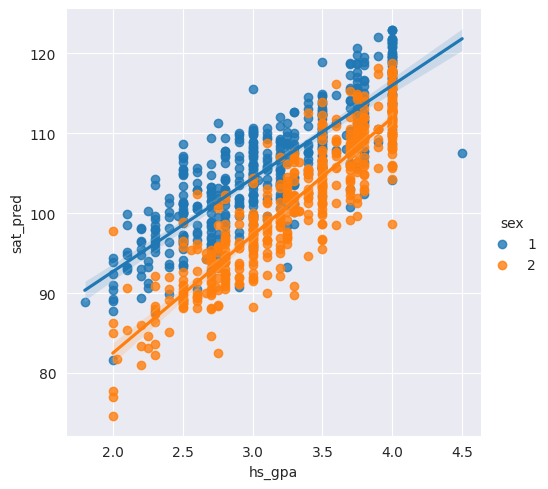

In [158]:
df["sat_pred"] = model(x)

sns.lmplot(data=df, x="hs_gpa", y="sat_pred", hue="sex", ci=99)

#np.corrcoef(model(x)[:, 0].numpy(), t_mod[:, 1])
pd.get_dummies(df["sex"]).corrwith(df["sat_pred"], method="spearman")

In [159]:
def min_bias_loss(y_true, y_pred, loss=tf.keras.losses.mean_squared_error):
  return loss(y_true[:, :1], y_pred) * (tf.math.abs(tfp.stats.covariance(y_true[:, 1:], y_pred)) + 1)  # / tf.keras.losses.kullback_leibler_divergence(y_true[:, 1:], y_pred) 

#def loss_func(y_true, y_pred):
#  return tf.keras.losses.mean_squared_error(y_true[:, :1], y_pred) - tf.keras.losses.binary_crossentropy(y_true[:, 1:] - 1, y_pred, from_logits=True)  # / tf.keras.losses.kullback_leibler_divergence(y_true[:, 1:], y_pred)

#def loss_func(y_true, y_pred, loss=tf.keras.losses.mean_squared_error):
#  l_pq = tf.keras.losses.kullback_leibler_divergence(y_true[:, 1:], y_pred) 
#  l_qp = tf.keras.losses.kullback_leibler_divergence(y_pred, y_true[:, 1:])
#  return loss(y_true[:, :1], y_pred) - (l_pq + l_qp) / 2


In [160]:
model = tf.keras.Sequential([
                              tf.keras.layers.Dense(32, activation="relu"),
                              tf.keras.layers.Dense(8, activation="relu"),
                             tf.keras.layers.Dense(1, activation=None),
                              ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = min_bias_loss, metrics=r2_score)

In [161]:
model.fit(x, t_mod, validation_split=0.1, shuffle=True, batch_size=64, epochs=500)

Epoch 1/500
15/15 [==============================] - 2s 28ms/step - loss: 10925.8516 - r2_score: 0.2363 - val_loss: 11329.5527 - val_r2_score: 0.2429
Epoch 2/500
15/15 [==============================] - 0s 7ms/step - loss: 10765.8633 - r2_score: 0.2315 - val_loss: 11243.0859 - val_r2_score: 0.2679
Epoch 3/500
15/15 [==============================] - 0s 7ms/step - loss: 10717.4463 - r2_score: 0.2270 - val_loss: 11265.0791 - val_r2_score: 0.2562
Epoch 4/500
15/15 [==============================] - 0s 6ms/step - loss: 10721.2129 - r2_score: 0.2187 - val_loss: 11224.0049 - val_r2_score: 0.2974
Epoch 5/500
15/15 [==============================] - 0s 7ms/step - loss: 10704.7891 - r2_score: 0.2666 - val_loss: 11188.6211 - val_r2_score: 0.2925
Epoch 6/500
15/15 [==============================] - 0s 7ms/step - loss: 10631.8955 - r2_score: 0.2219 - val_loss: 11193.2637 - val_r2_score: 0.2624
Epoch 7/500
15/15 [==============================] - 0s 7ms/step - loss: 10624.7803 - r2_score: 0.2009 - 

1    0.008062
2   -0.008062
dtype: float64

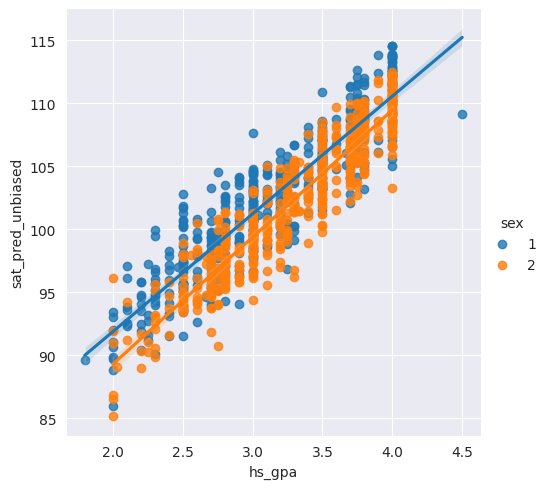

In [162]:
df["sat_pred_unbiased"] = model(x)

sns.lmplot(data=df, x="hs_gpa", y="sat_pred_unbiased", hue="sex", ci=99)

#np.corrcoef(model(x)[:, 0].numpy(), t_mod[:, 1])
pd.get_dummies(df["sex"]).corrwith(df["sat_pred_unbiased"], method="spearman")

## Bias in Criminal Convictions

In [ ]:
!git clone https://github.com/datadesk/homeless-arrests-analysis.git
!unzip /content/homeless-arrests-analysis/arrests.zip

In [ ]:
df = pd.read_feather("/content/arrests.feather")
df

,booking_num,homeless,arrest_year,arrest_ymd,booking_ymd,gender,race,age,occupation,charge_code,charge_desc
0,2497688,0.0,2011.0,2011-01-01,2011-01-01,M,W,25.0,ENGINEER,23152(A)VC,drunk-driving-alcoholdrugs
1,2497689,0.0,2011.0,2011-01-01,2011-01-01,M,H,38.0,AGENT,23152(A)VC,drunk-driving-alcoholdrugs
2,2497690,0.0,2011.0,2011-01-01,2011-01-01,M,W,25.0,BUSINESS DEV,23152(A)VC,drunk-driving-alcoholdrugs
3,2497697,0.0,2011.0,2011-01-01,2011-01-01,F,W,40.0,NONE,273.5(A)PC,corporal-injury-on-spousecohabitantet
4,2497698,0.0,2011.0,2011-01-01,2011-01-01,M,H,34.0,LABORER,12021(A)PC,poss-firearm-by-convictd-felonaddicte-1
...,...,...,...,...,...,...,...,...,...,...,...
743942,4870887,0.0,2016.0,2016-12-31,2017-01-01,M,B,24.0,LABORER,12500(A)VC,unlicensed-driver
743943,4870906,0.0,2016.0,2016-12-31,2017-01-01,M,H,21.0,LABORER,484(A)PC,grand-theft-over-400
743944,4871191,0.0,2016.0,2016-12-31,2017-01-01,M,H,19.0,UNEMPLOYED,148(A)(1)PC,resisting-officer
743945,4871193,0.0,2016.0,2016-12-31,2017-01-01,M,H,22.0,FORK LIFT DRIVE,236PC,false-imprisonment


In [ ]:
CODE_DICT = {
              "PC": "Penal Code",
              "HS": "Health and Safety Code",
              "VC": "Vehicle Code",
              #"BP": "Business and Professions Code",
              #"WI": "Welfare and Institutions Code",
              #"RT": "Revenue and Taxation Code",
              #"PU": "Public Utilitie Codes",
              #"UI": "Unemployment Insurance Code",
              #"IC": "Insurance Code",
              #"US": "US Law?",
              #"MC": "Municipal Code (Any City)",
             }

def law_code(series):
  out = []
  for idx, field in enumerate(series):
    cur = "Other"
    for key, value in CODE_DICT.items():   
      if key in str(field):
        cur = value
    out.append(cur)
  return out

In [ ]:
# create a mapping for the applied law code
df["law_code"] = law_code(df["charge_code"])

df["Penal Code"] = df["law_code"] == "Penal Code"
df["Vehicle Code"] = df["law_code"] == "Vehicle Code"
df["Health and Safety Code"] = df["law_code"] == "Health and Safety Code"

# map race variables from letters to names
r_map = dict({"W":"White", "H":"Hispanic", "B":"Black", "A":"Other"},
             **{x:"Other" for x in ("A", "C", "F", "I", "J", "K", "O", "P")})
df["race"] = df["race"].map(r_map)

# rename seldomly occuring occuptations to "Other"
df["occupation"][df["occupation"].isin(list(df.occupation.value_counts()[df.occupation.value_counts() < 1000].index))] = "Other"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df

,booking_num,homeless,arrest_year,arrest_ymd,booking_ymd,gender,race,age,occupation,charge_code,charge_desc,law_code,Penal Code,Vehicle Code,Health and Safety Code
0,2497688,0.0,2011.0,2011-01-01,2011-01-01,M,White,25.0,Other,23152(A)VC,drunk-driving-alcoholdrugs,Vehicle Code,False,True,False
1,2497689,0.0,2011.0,2011-01-01,2011-01-01,M,Hispanic,38.0,Other,23152(A)VC,drunk-driving-alcoholdrugs,Vehicle Code,False,True,False
2,2497690,0.0,2011.0,2011-01-01,2011-01-01,M,White,25.0,Other,23152(A)VC,drunk-driving-alcoholdrugs,Vehicle Code,False,True,False
3,2497697,0.0,2011.0,2011-01-01,2011-01-01,F,White,40.0,NONE,273.5(A)PC,corporal-injury-on-spousecohabitantet,Penal Code,True,False,False
4,2497698,0.0,2011.0,2011-01-01,2011-01-01,M,Hispanic,34.0,LABORER,12021(A)PC,poss-firearm-by-convictd-felonaddicte-1,Penal Code,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743942,4870887,0.0,2016.0,2016-12-31,2017-01-01,M,Black,24.0,LABORER,12500(A)VC,unlicensed-driver,Vehicle Code,False,True,False
743943,4870906,0.0,2016.0,2016-12-31,2017-01-01,M,Hispanic,21.0,LABORER,484(A)PC,grand-theft-over-400,Penal Code,True,False,False
743944,4871191,0.0,2016.0,2016-12-31,2017-01-01,M,Hispanic,19.0,UNEMPLOYED,148(A)(1)PC,resisting-officer,Penal Code,True,False,False
743945,4871193,0.0,2016.0,2016-12-31,2017-01-01,M,Hispanic,22.0,Other,236PC,false-imprisonment,Penal Code,True,False,False


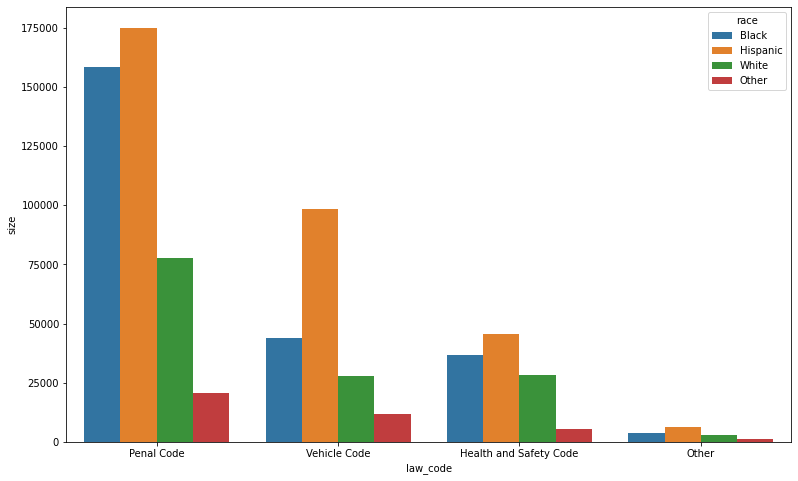

In [ ]:

df_count = df.groupby(["race", "law_code"]).size().to_frame(name = 'size').reset_index()

plt.figure(figsize=(13, 8))
sns.barplot(x="law_code", y="size", hue="race", data=df_count,
            order=["Penal Code", "Vehicle Code", "Health and Safety Code", "Other"],
            hue_order=["Black", "Hispanic", "White", "Other"])

In [ ]:
pd.get_dummies(df["race"]).corrwith(df["homeless"], method="spearman")

Black       0.057874
Hispanic   -0.133712
Other      -0.043758
White       0.126320
dtype: float64

In [ ]:
x = np.concatenate([pd.get_dummies(df["occupation"]).to_numpy(),
                    df[["homeless", "age"]]], axis=1).astype(float)

y = df["Penal Code"].to_numpy().astype(float)

In [ ]:
model = tf.keras.Sequential([
                              tf.keras.layers.Dense(128, activation="relu"),
                              tf.keras.layers.Dense(64, activation="relu"),
                              tf.keras.layers.Dense(32, activation="relu"),
                              tf.keras.layers.Dense(8, activation="relu"),
                              tf.keras.layers.Dense(1, activation="sigmoid"),
                              ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "BCE", metrics=["accuracy"])

In [ ]:
model.fit(x, y[:, None], validation_split=0.2, batch_size=256, shuffle=True, epochs=10)

Epoch 1/20
2325/2325 [==============================] - 9s 4ms/step - loss: 0.6717 - accuracy: 0.5888 - val_loss: 0.6501 - val_accuracy: 0.6340
Epoch 2/20
2325/2325 [==============================] - 8s 4ms/step - loss: 0.6683 - accuracy: 0.5945 - val_loss: 0.6421 - val_accuracy: 0.6398
Epoch 3/20
2325/2325 [==============================] - 8s 4ms/step - loss: 0.6663 - accuracy: 0.5972 - val_loss: 0.6396 - val_accuracy: 0.6419
Epoch 4/20
2325/2325 [==============================] - 9s 4ms/step - loss: 0.6657 - accuracy: 0.5981 - val_loss: 0.6455 - val_accuracy: 0.6396
Epoch 5/20
2325/2325 [==============================] - 9s 4ms/step - loss: 0.6654 - accuracy: 0.5981 - val_loss: 0.6464 - val_accuracy: 0.6398
Epoch 6/20
2325/2325 [==============================] - 8s 4ms/step - loss: 0.6653 - accuracy: 0.5985 - val_loss: 0.6422 - val_accuracy: 0.6409
Epoch 7/20
2325/2325 [==============================] - 9s 4ms/step - loss: 0.6652 - accuracy: 0.5983 - val_loss: 0.6434 - val_accuracy:

In [ ]:
pd.get_dummies(df["race"]).corrwith(pd.Series(model(x)[:, 0]), method="spearman")

Black       0.123140
Hispanic   -0.104760
Other      -0.068310
White       0.024499
dtype: float64

In [ ]:
# concatenate a one hot encoding of the race variable into our loss
y_m = np.concatenate([df["Penal Code"][:, np.newaxis], pd.get_dummies(df["race"])], axis=1).astype(float)

def bias_loss(y_true, y_pred):
  return tf.keras.losses.binary_crossentropy(y_true[:, :1], y_pred) * (tf.math.reduce_prod([tf.math.abs(tfp.stats.correlation(y_true[:, i:i+1], y_pred)) for i in range(1, y_true.shape[1])]) + 0.01)  #* tf.math.abs(tfp.stats.correlation(y_true[:, 1:], y_pred))  #/ tf.keras.losses.kullback_leibler_divergence(y_true[:, 1], y_pred)

def bias_acc(y_true, y_pred):
  return tf.keras.metrics.binary_accuracy(y_true[:, :1], y_pred)

model = tf.keras.Sequential([
                              tf.keras.layers.Dense(128, activation="relu"),
                              tf.keras.layers.Dense(64, activation="relu"),
                              tf.keras.layers.Dense(32, activation="relu"),
                              tf.keras.layers.Dense(8, activation="relu"),
                              tf.keras.layers.Dense(1, activation="sigmoid"),
                              ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=bias_loss, metrics=bias_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [ ]:
model.fit(x, y_m, validation_split=0.2, batch_size=256, shuffle=True, epochs=10)

Epoch 1/20
2325/2325 [==============================] - 18s 7ms/step - loss: 0.0068 - bias_acc: 0.5797 - val_loss: nan - val_bias_acc: 0.5704
Epoch 2/20
2325/2325 [==============================] - 15s 6ms/step - loss: 0.0067 - bias_acc: 0.5889 - val_loss: nan - val_bias_acc: 0.6229
Epoch 3/20
2325/2325 [==============================] - 15s 6ms/step - loss: 0.0067 - bias_acc: 0.5906 - val_loss: nan - val_bias_acc: 0.6112
Epoch 4/20
2325/2325 [==============================] - 15s 6ms/step - loss: 0.0067 - bias_acc: 0.5933 - val_loss: nan - val_bias_acc: 0.6412
Epoch 5/20
2325/2325 [==============================] - 15s 6ms/step - loss: 0.0067 - bias_acc: 0.5951 - val_loss: nan - val_bias_acc: 0.6331
Epoch 6/20
2325/2325 [==============================] - 15s 6ms/step - loss: 0.0067 - bias_acc: 0.5960 - val_loss: nan - val_bias_acc: 0.6393
Epoch 7/20
2325/2325 [==============================] - 16s 7ms/step - loss: 0.0067 - bias_acc: 0.5969 - val_loss: nan - val_bias_acc: 0.6401
Epoch 

In [ ]:
pd.get_dummies(df["race"]).corrwith(pd.Series(model(x)[:, 0]), method="spearman")

Black       0.077009
Hispanic   -0.039611
Other      -0.067603
White      -0.003479
dtype: float64